In [7]:
import re
import locale

import warnings

from glob import glob
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib as mpl

import tabula as tb

import pytz

# set locale and timezone
locale.setlocale(locale.LC_ALL, "de_DE.utf8")
TZ = pytz.timezone("Europe/Berlin")

# ignore pd user warnings
warnings.filterwarnings("ignore")

# constants
URL = "https://www.landtag.nrw.de/portal/WWW/dokumentenarchiv/Dokument/MMD18-8616.pdf"
STUD_CSV = glob("data/studis.csv")[0]
LR_URL = "https://de.wikipedia.org/wiki/Landesregierung_Nordrhein-Westfalen"

# options for tabula
pd_options = {"header": None, "names": ["jahr", "betrag"]}

# colors from https://personal.sron.nl/~pault/#textmarking
vibrant_colors = {
    "blue": "#4477AA",
    "cyan": "#66CCEE",
    "green": "#228833",
    "yellow": "#CCBB44",
    "red": "#EE6677",
    "purple": "#AA3377",
    "grey": "#BBBBBB",
}

# parteifarben
party_colors = {
    "SPD": "#E3000F",
    "CDU": "#151518",
    "FDP": "#FFED00",
    "Bündnis 90/Die Grünen": "#409A3C",
}

In [8]:
dfs = tb.read_pdf(
    URL, pages=[2, 3], multiple_tables=True, stream=True, pandas_options=pd_options
)
stud_df_raw = pd.read_csv(STUD_CSV, header=None, names=["semester", "anzahl"])

# get Landesregierungs data from wikipedia table
lr_df = pd.read_html(LR_URL, header=0)[0]

In [9]:
land_df: pd.DataFrame = dfs[0]
# convert jahr col to a datetime object
land_df["jahr"] = pd.to_datetime(land_df["jahr"], format="%Y", errors="coerce")
# convert betrag col to a int object
land_df["betrag"] = (
    land_df["betrag"].astype(str).apply(lambda x: re.sub(r"[^\d]", "", x)).astype(int)
)
land_df.rename(columns={"betrag": "betrag land"}, inplace=True)

studi_df: pd.DataFrame = dfs[1]
# convert jahr col to a datetime object
studi_df["jahr"] = pd.to_datetime(studi_df["jahr"], format="%Y", errors="coerce")
# convert betrag col to a int object
studi_df["betrag"] = (
    studi_df["betrag"].astype(str).apply(lambda x: re.sub(r"[^\d]", "", x)).astype(int)
)
studi_df.rename(columns={"betrag": "betrag studis"}, inplace=True)

stud_count_df = pd.DataFrame()
# convert semester col to a datetime object, add one year to the date to get a more accurate year
stud_count_df["jahr"] = pd.to_datetime(
    stud_df_raw["semester"].astype(str).apply(lambda x: re.findall(r"(\d{4})", x)[0]),
    format="%Y",
    errors="coerce",
) + pd.DateOffset(years=1)
stud_count_df["anzahl studierende"] = (
    stud_df_raw["anzahl"]
    .astype(str)
    .apply(lambda x: re.sub(r"[^\d]", "", x))
    .astype(int)
)

# trim LR data
lr_df["von"] = pd.to_datetime(lr_df["von"], format="%d. %B %Y", errors="coerce")
lr_df["bis"] = pd.to_datetime(lr_df["bis"], format="%d. %B %Y", errors="coerce")
# set the end date to 2027-06-15 if it is missing (~ amtszeit of the current government)
lr_df["bis"].replace(
    {np.nan: pd.to_datetime("2027-06-15", format="%Y-%m-%d", errors="coerce")},
    inplace=True,
)
# remove all rows where "von" < 1990
lr_df = lr_df[lr_df["von"].dt.year >= 1990]

# split the "Regierungsparteien" column into a list of parties and add a column with the coalition colors
lr_df["Regierungsparteien"] = lr_df["Regierungsparteien"].apply(
    lambda x: x.split(", ") if x.split(", ") else [x]
)
lr_df["koa_colors"] = lr_df["Regierungsparteien"].apply(
    lambda x: [party_colors[party] for party in x]
)
lr_df["Regierungsparteien_kurz"] = lr_df["Regierungsparteien"].apply(
    lambda x: [y.replace("Bündnis 90/Die Grünen", "Grüne") for y in x]
)
lr_df["von"] = lr_df["von"].dt.tz_localize(TZ)
lr_df["bis"] = lr_df["bis"].dt.tz_localize(TZ)
print(
    lr_df[["von", "bis", "Regierungsparteien", "Regierungsparteien_kurz", "koa_colors"]]
)

dfs_to_combine = [land_df, studi_df, stud_count_df]

# set the index to the year
land_df["jahr"] = land_df["jahr"].dt.tz_localize(TZ)
land_df = land_df.set_index("jahr")
studi_df["jahr"] = studi_df["jahr"].dt.tz_localize(TZ)
studi_df = studi_df.set_index("jahr")
stud_count_df["jahr"] = stud_count_df["jahr"].dt.tz_localize(TZ)
stud_count_df = stud_count_df.set_index("jahr")

                         von                       bis  \
16 1990-06-12 00:00:00+02:00 1995-07-17 00:00:00+02:00   
17 1995-07-17 00:00:00+02:00 1998-06-09 00:00:00+02:00   
18 1998-06-09 00:00:00+02:00 2000-06-27 00:00:00+02:00   
19 2000-06-27 00:00:00+02:00 2002-11-12 00:00:00+01:00   
20 2002-11-12 00:00:00+01:00 2005-06-24 00:00:00+02:00   
21 2005-06-24 00:00:00+02:00 2010-07-15 00:00:00+02:00   
22 2010-07-15 00:00:00+02:00 2012-06-21 00:00:00+02:00   
23 2012-06-21 00:00:00+02:00 2017-06-30 00:00:00+02:00   
24 2017-06-30 00:00:00+02:00 2021-10-28 00:00:00+02:00   
25 2021-10-28 00:00:00+02:00 2022-06-29 00:00:00+02:00   
26 2022-06-29 00:00:00+02:00 2027-06-15 00:00:00+02:00   

              Regierungsparteien Regierungsparteien_kurz          koa_colors  
16                         [SPD]                   [SPD]           [#E3000F]  
17  [SPD, Bündnis 90/Die Grünen]            [SPD, Grüne]  [#E3000F, #409A3C]  
18  [SPD, Bündnis 90/Die Grünen]            [SPD, Grüne]  [#E3000F

In [10]:
# combine the dataframes on the index (year)
df = pd.concat([land_df, studi_df, stud_count_df], axis=1)
print(df.head(10), "\n", df.dtypes)

# calculate the total budget
df["gesamtbetrag"] = df["betrag land"] + df["betrag studis"]

# calculate the budget pro student and land budget pro student
df["betrag pro studi"] = df["gesamtbetrag"] / df["anzahl studierende"]
df["betrag pro studi land"] = df["betrag land"] / df["anzahl studierende"]
df["betrag pro studi studi"] = df["betrag studis"] / df["anzahl studierende"]

# calculate the ratio of the land budget to the total budget pro student
df["land budget ratio"] = df["betrag land"] / df["gesamtbetrag"]
# calculate the ratio of the student budget to the total budget pro student
df["student budget ratio"] = df["betrag studis"] / df["gesamtbetrag"]

# round the ratios to 2 decimal places
df["land budget ratio"] = df["land budget ratio"].round(2)
df["student budget ratio"] = df["student budget ratio"].round(2)

                           betrag land  betrag studis  anzahl studierende
jahr                                                                     
1994-01-01 00:00:00+01:00     38868409     23500000.0                 NaN
1995-01-01 00:00:00+01:00     38141236     24500000.0                 NaN
1996-01-01 00:00:00+01:00     39079935     25500000.0                 NaN
1997-01-01 00:00:00+01:00     39603321     27300000.0                 NaN
1998-01-01 00:00:00+01:00     40801092     26600000.0                 NaN
1999-01-01 00:00:00+01:00     40801091     26600000.0            515678.0
2000-01-01 00:00:00+01:00     40801092     25858000.0            506510.0
2001-01-01 00:00:00+01:00     40801091     29370000.0            506285.0
2002-01-01 00:00:00+01:00     41160000     31281000.0            517267.0
2003-01-01 00:00:00+01:00     40660000     35309000.0            523283.0 
 betrag land             int32
betrag studis         float64
anzahl studierende    float64
dtype: object


In [11]:
# format into a table with html template

template = """
<!DOCTYPE html>
<html>
<head>
<style>
table {{
  font-family: Arial, sans-serif;
  border-collapse: collapse;
  width: 100%;
}}

td, th {{
    border: 1px solid #dddddd;
    text-align: left;
    padding: 8px;
    }}
    
tr:nth-child(even) {{
    background-color: #f2f2f2;
}}
</style>
</head>
<body>

<h2>Budget pro Student</h2>

<table>
  <tr>
    <th>Jahr</th>
    <th>Betrag Land</th>
    <th>Betrag Studis</th>
    <th>Anzahl Studierende</th>
    <th>Gesamtbetrag</th>
    <th>Betrag pro Student</th>
    <th>betrag pro studi land</th>
    <th>Land Budget Ratio</th>
    <th>Student Budget Ratio</th>
  </tr>
  {}
</table>

</body>
</html>
"""

rows = ""

for index, row in df.iterrows():
    rows += f"""
    <tr>
        <td>{index.year}</td>
        <td>{row["betrag land"]}</td>
        <td>{row["betrag studis"]}</td>
        <td>{row["anzahl studierende"]}</td>
        <td>{row["gesamtbetrag"]}</td>
        <td>{row["betrag pro studi"]}</td>
        <td>{row["betrag pro studi land"]}</td>
        <td>{row["land budget ratio"]}</td>
        <td>{row["student budget ratio"]}</td>
    </tr>
    """

with open("data/budget.html", "w") as f:
    f.write(template.format(rows))

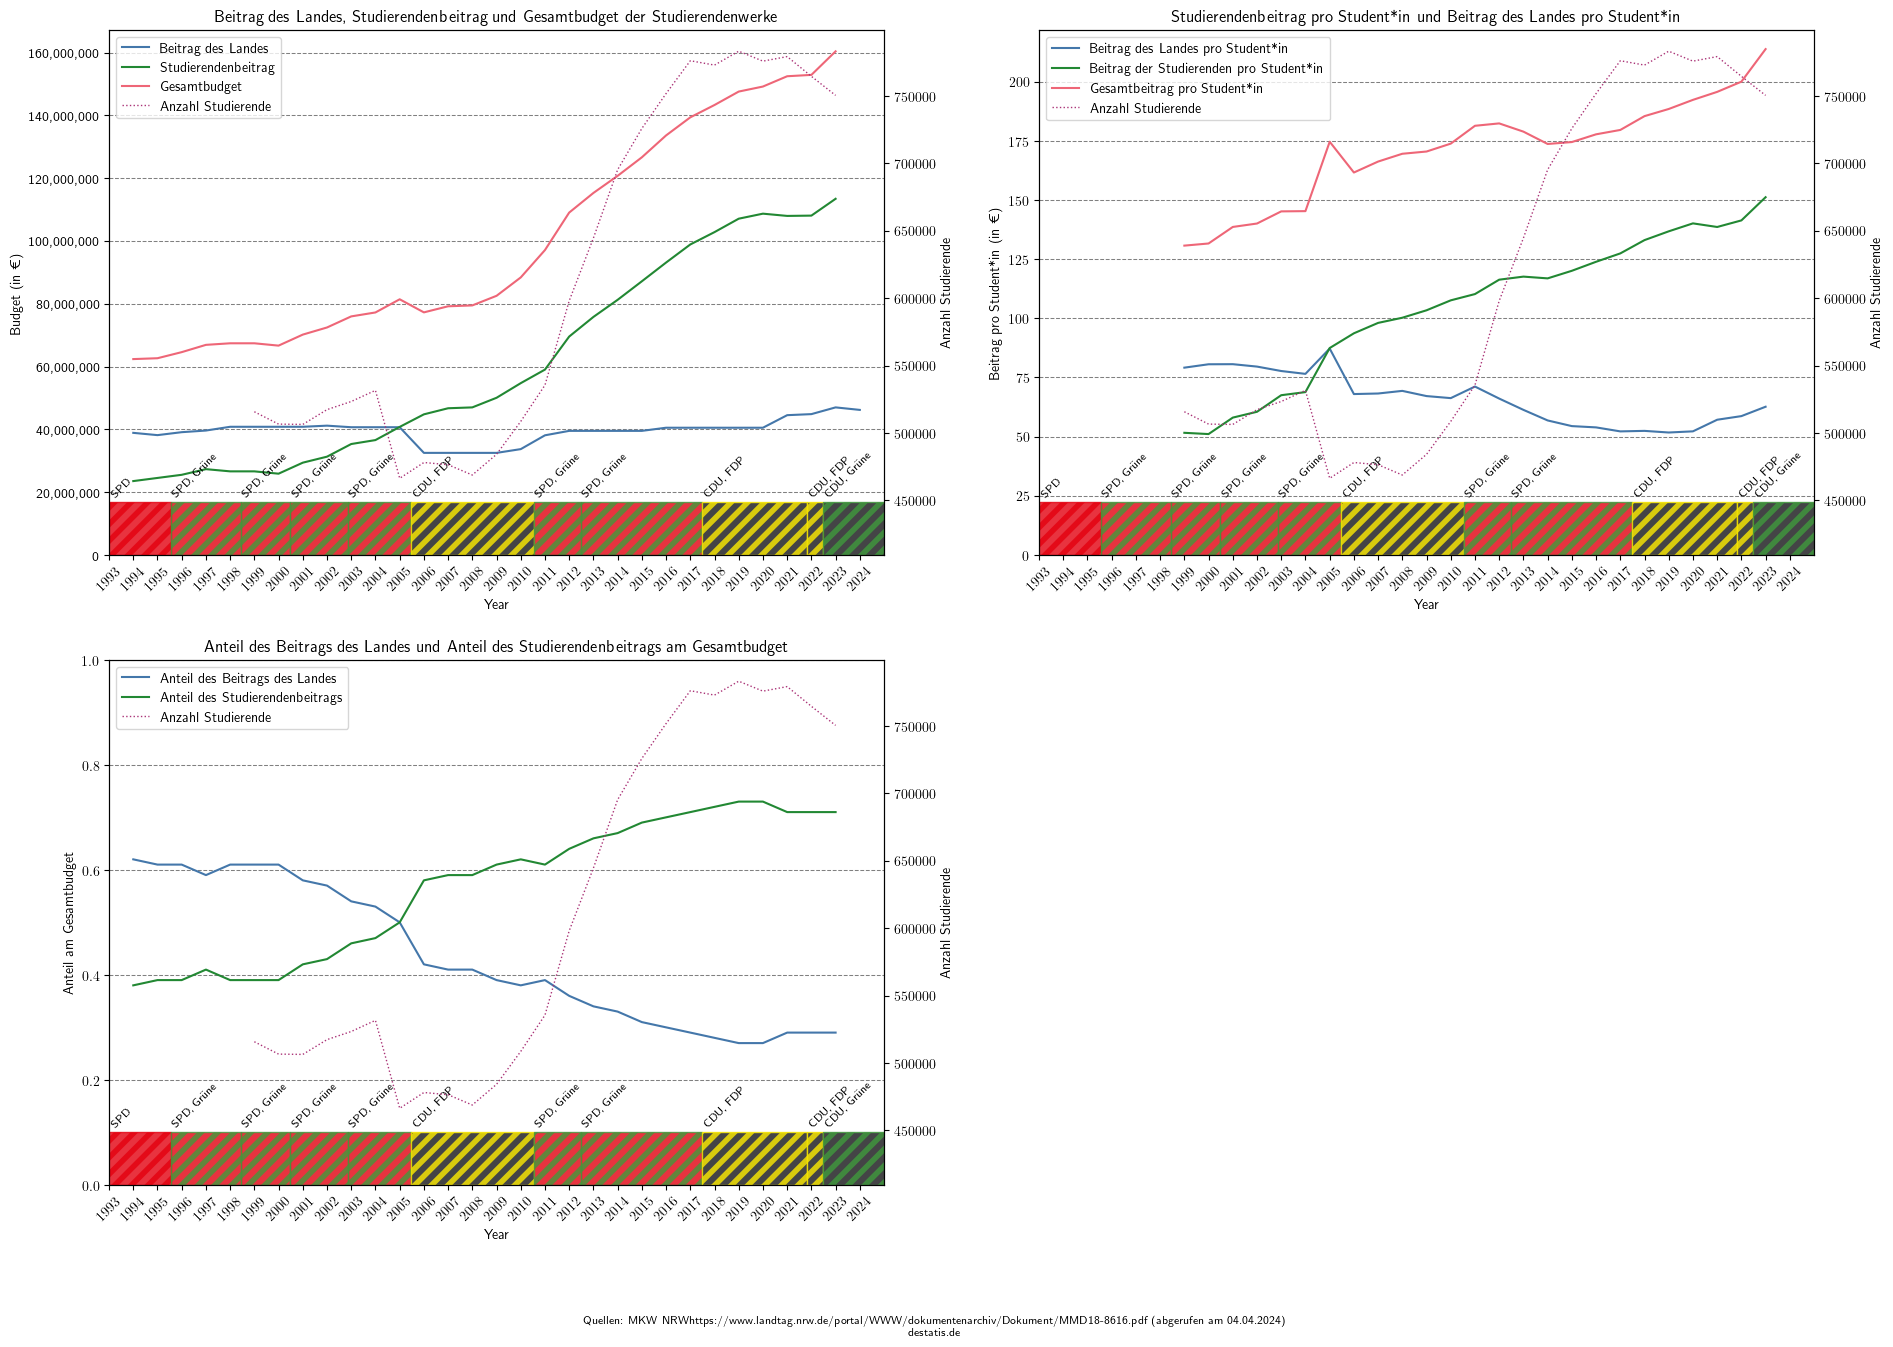

In [12]:
min_date = mpl.dates.date2num(df.index.min() - pd.DateOffset(years=1))
max_date = mpl.dates.date2num(df.index.max() + pd.DateOffset(years=1))
plt.rcParams.update({"hatch.linewidth": 4})

# plot the data
fig = plt.figure(tight_layout=True, figsize=(22, 15))

gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax0 = fig.add_subplot(
    gs[0, :2],
)
ax1 = fig.add_subplot(gs[0, 2:])
ax2 = fig.add_subplot(gs[1, :2])
subplots = [ax0, ax1, ax2]
# fig, ax0 = plt.subplots(2, 2)

# plot the land budget and student budget over the years with the total budget as well
ax0.plot(
    df.index,
    df["betrag land"],
    label="Beitrag des Landes",
    color=vibrant_colors["blue"],
)
ax0.plot(
    df.index,
    df["betrag studis"],
    label="Studierendenbeitrag",
    color=vibrant_colors["green"],
)
ax0.plot(
    df.index, df["gesamtbetrag"], label="Gesamtbudget", color=vibrant_colors["red"]
)
ax0.set_title(
    "Beitrag des Landes, Studierendenbeitrag und Gesamtbudget der Studierendenwerke"
)
ax0.set_ylabel("Budget (in €)")
ax0.set_xlabel("Year")
ax0.legend()
ax0.set_xlim(xmin=min_date, xmax=max_date)
ax0.xaxis.set_major_locator(mdates.YearLocator())
ax0.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax0.yaxis.set_major_formatter(
    mpl.ticker.StrMethodFormatter("{x:,.0f}")
)  # add thousand separator to y-axis
ax0.set_ylim(ymin=0)

# plot the budget pro student and land over the years
ax1.plot(
    df.index,
    df["betrag pro studi land"],
    label="Beitrag des Landes pro Student*in",
    color=vibrant_colors["blue"],
)
ax1.plot(
    df.index,
    df["betrag pro studi studi"],
    label="Beitrag der Studierenden pro Student*in",
    color=vibrant_colors["green"],
)
ax1.plot(
    df.index,
    df["betrag pro studi"],
    label="Gesamtbeitrag pro Student*in",
    color=vibrant_colors["red"],
)
ax1.set_title(
    "Studierendenbeitrag pro Student*in und Beitrag des Landes pro Student*in"
)
ax1.set_ylabel("Beitrag pro Student*in (in €)")
ax1.set_xlabel("Year")
ax1.legend()
ax1.set_xlim(xmin=min_date, xmax=max_date)
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax1.set_ylim(ymin=0)

# plot the land budget ratio and student budget ratio over the years
ax2.plot(
    df.index,
    df["land budget ratio"],
    label="Anteil des Beitrags des Landes",
    color=vibrant_colors["blue"],
)
ax2.plot(
    df.index,
    df["student budget ratio"],
    label="Anteil des Studierendenbeitrags",
    color=vibrant_colors["green"],
)
ax2.set_title(
    "Anteil des Beitrags des Landes und Anteil des Studierendenbeitrags am Gesamtbudget"
)
ax2.set_ylabel("Anteil am Gesamtbudget")
ax2.set_xlabel("Year")
ax2.legend()
ax2.set_xlim(xmin=min_date, xmax=max_date)
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax2.set_ylim(ymin=0, ymax=1)

# plot the number of students over the years into each subplot (ax0, ax1, ax2)
for ax in subplots:
    axt = ax.twinx()
    axt.plot(
        df.index,
        df["anzahl studierende"],
        color=vibrant_colors["purple"],
        label="Anzahl Studierende",
        linestyle="dotted",
        linewidth=1,
    )
    axt.set_ylabel("Anzahl Studierende")
    axt.set_ylim(ymin=axt.get_ylim()[0] / 1.1)
    # combine the legends of the two plots
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = axt.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc="upper left")

    # turn the x-axis labels by 45 degrees
    ax.tick_params(axis="x", labelrotation=45)

    # add grid to the plot
    ax.grid(True, axis="y", linestyle="--", linewidth=0.75, color="gray")

    # add rectangle for the coalition colors
    # norm the min and max values to the same scale as the plot
    for _, row in lr_df.iterrows():
        fc = row["koa_colors"][0]
        ec = row["koa_colors"][1] if len(row["koa_colors"]) > 1 else fc
        ax.axvspan(
            row["von"],
            row["bis"],
            facecolor=fc,
            edgecolor=ec,
            alpha=0.8,
            hatch=r"//",
            ymax=0.1,
        )
        txt_start = (
            row["von"]
            if row["von"] > df.index.min() - pd.DateOffset(years=1)
            else min_date + 0
        )
        ax.text(
            txt_start,
            ax.get_ylim()[1] * 0.11,
            f"{', '.join(row['Regierungsparteien_kurz'])}",
            rotation=45,
            fontsize=8,
            color="black",
        )


# add sources to the plot
plt.rcParams.update(
    {
        "text.usetex": True,
    }
)
today = datetime.now().strftime("%d.%m.%Y")
plt.figtext(
    0.5,
    0.01,
    f"Quellen: MKW NRW{URL} (abgerufen am {today})\ndestatis.de",
    ha="center",
    fontsize=8,
)


plt.savefig("data/budget_plot.png")